[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alucantonio/data_enhanced_simulation/blob/master/FlaxIntro.ipynb)

# Neural Networks with JAX: the Flax library

Flax is an open source Python neural network library built on top of JAX. Here, we will use NNX (Neural Networks for JAX), a new high-level interface that is part of Flax and provides an intuitive framework to build and train neural networks.

Link to the docs: https://flax.readthedocs.io/en/latest/quick_start.html

In [1]:
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt

from flax import nnx
import optax # optimization methods for JAX

from sklearn.model_selection import train_test_split

In [2]:
!pip install tqdm
from tqdm.notebook import tqdm # progress bar

In [3]:
# Support for interactive plots
!pip install ipywidgets
!pip install ipympl

## A linear regression problem

To learn using NNX, let's solve a simple linear regression problem.

In [2]:
# Defining a toy dataset
n_samples = 150
x_dim = 2  # putting small numbers here so that we can visualize the data easily
y_dim = 1
noise_amplitude = 0.1

# Generate (random) parameters for a linear model
key, w_key, b_key = random.split(random.key(seed=42), num=3)
W = random.normal(w_key, (x_dim, y_dim))  # weight
b = random.normal(b_key, (y_dim,))  # bias

# Generate samples with noise added to the linear model
key, x_key, noise_key = random.split(key, num=3)
xs = random.normal(x_key, (n_samples, x_dim))
ys = jnp.dot(xs, W) + b
ys += noise_amplitude * random.normal(noise_key, (n_samples, y_dim))
print(f'xs shape = {xs.shape} ; ys shape = {ys.shape}')

xs shape = (150, 2) ; ys shape = (150, 1)


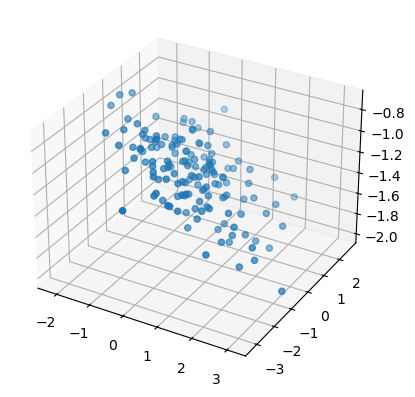

In [3]:
# Let's visualize our data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
assert xs.shape[-1] == 2 and ys.shape[-1] == 1  # low dimensional data so that we can plot it
ax.scatter(xs[:, 0], xs[:, 1], zs=ys)

In [3]:
# Split dataset into train and test (80-20), with shuffling (default)
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.2)
xs_train.shape, xs_test.shape
ys_test.shape, ys_train.shape
# Notice that we assume that the labels are COLUMN vectors!

((30, 1), (120, 1))

To solve the linear regression problem using a neural network, let us create a subclass of the `nnx.Module` class. In particular, we have to implement the `__init__()` and `__call__()` methods.

In [3]:
# Define a custom NN
class Model(nnx.Module):
  # The constructor takes dims of inputs and outputs as parameters
  # to define hidden/output layers with the appropriate shapes
  def __init__(self, din, dout, rngs: nnx.Rngs):
    # Definition of hidden/output layers goes here
    self.linear = nnx.Linear(din, dout, rngs=rngs)

  def __call__(self, x):
    # Forward model evaluation
    return self.linear(x)

# Create a neural network by instantiating the custom class Model
model = Model(x_dim, y_dim, rngs=nnx.Rngs(0))

Basic recipe for implementing the core training functions:
- define the _loss_ function
- choose the _optimizer_ (SGD, Adam, ...)
- define a training step performing the update of model parameters for a _batch_ of training data
- define a training epoch that perform multiple batch training steps to cover all the training set

In [4]:
# Define the optimizer
lr = 0.1 # learning rate
optimizer = nnx.Optimizer(model, optax.adam(lr)) # Adam optimizer

# MSE loss
def loss_fn(model, x, y_target):
   y_pred = model(x)
   return ((y_pred - y_target) ** 2).mean()
   # You can also use losses already implemented in optax
   # return optax.losses.squared_error(predictions=y_pred, targets=y).mean()

# Training step (= one batch evaluation/params update)
@nnx.jit # jit with automatic handling of nnx objects as parameters
def train_step(model, optimizer, x, y):
  loss, grads = nnx.value_and_grad(loss_fn)(model, x, y) # get loss and gradients using JAX autodiff
  optimizer.update(grads) # update parameters of the model according to the optimizer
  return loss

# Train for a single epoch
def train_epoch(model, optimizer, xs_train, ys_train, xs_test, ys_test, batch_size, rng):
  train_ds_size = len(xs_train)
  steps_per_epoch = train_ds_size // batch_size

  perms = random.permutation(rng, len(xs_train)) # shuffle dataset (permutation of samples order)
  perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []

  for perm in perms:
    batch_xs = xs_train[perm, :]
    batch_ys = ys_train[perm, :]
    loss = train_step(model, optimizer, batch_xs, batch_ys)
    epoch_loss.append(loss) # store training loss for the current batch

  train_loss = np.mean(epoch_loss)
  test_loss = loss_fn(model, xs_test, ys_test)
  return model, train_loss, test_loss

Let's train the model!

In [9]:
epochs = 50
log_period_epoch = 10
batch_size = 32

train_loss_history = []
test_loss_history = []

# Training loop
for epoch in tqdm(range(1, epochs + 1)):
    model, train_loss, test_loss = train_epoch(model, optimizer, xs_train, ys_train,
                                               xs_test, ys_test, batch_size, random.key(1))

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    if epoch == 1 or epoch % log_period_epoch == 0:
        print(f'epoch {epoch}, training loss = {train_loss}, test loss = {test_loss}')

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 1, training loss = 1.3440322875976562, test loss = 0.8435845375061035
epoch 10, training loss = 0.06335179507732391, test loss = 0.05040886998176575
epoch 20, training loss = 0.008442187681794167, test loss = 0.008968953043222427
epoch 30, training loss = 0.008313319645822048, test loss = 0.009166252799332142
epoch 40, training loss = 0.0082181291654706, test loss = 0.009080123156309128
epoch 50, training loss = 0.008212990127503872, test loss = 0.00912840198725462


In [10]:
# Examine model parameters
print(model)

Model(
  linear=Linear(
    bias=Param(
      value=Array([-1.2314683], dtype=float32)
    ),
    bias_init=<function zeros at 0x13e2219e0>,
    dot_general=<function dot_general at 0x11fbe1440>,
    dtype=None,
    in_features=2,
    kernel=Param(
      value=Array(shape=(2, 1), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x14ff7cae0>,
    out_features=1,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  )
)


In [11]:
# Compare model parameters with the data-generating ones
print(model.linear.bias.value, b)
print(model.linear.kernel.value, W)

[-1.2314683] [-1.2226542]
[[-0.22637331]
 [-0.0020752 ]] [[-0.21746698]
 [ 0.01024477]]


(150, 1)


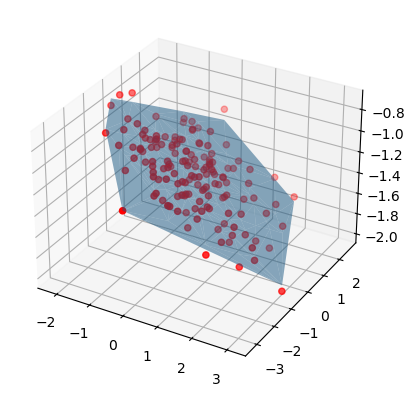

In [12]:
# Extract fitted model parameters and generate predictions
W = model.linear.kernel.value
b = model.linear.bias.value
pred = jnp.dot(xs, W) + b
print(pred.shape)

# Plot predictions along with data
# from google.colab import output
# output.enable_custom_widget_manager()
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[:, 0], xs[:, 1], zs=ys, color='r')
ax.plot_trisurf(xs[:, 0], xs[:, 1], pred.flatten(), alpha=0.5) # model plane

## Hyperparameter tuning via `GridSearchCV`

In [5]:
from sklearn.utils.estimator_checks import check_estimator, check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from train import train

In [46]:
# adapted from template https://github.com/scikit-learn-contrib/project-template/blob/main/skltemplate/_template.py

class MLPRegressor(BaseEstimator):

    _parameter_constraints = {
        "lr": [float],
        "epochs": [int],
        "batch_size": [int],
        "log_period_epoch": [int]
    }

    def __init__(self, model, lr, epochs, batch_size, log_period_epoch=10):
        # self.x_dim = x_dim
        # self.y_dim = y_dim
        self.model = model
        self._optimizer = nnx.Optimizer(self.model, optax.adam(lr)) # Adam optimizer
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.log_period_epoch = log_period_epoch

    @_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y):
        # `_validate_data` is defined in the `BaseEstimator` class.
        # It allows to:
        # - run different checks on the input data;
        # - define some attributes associated to the input data: `n_features_in_` and
        #   `feature_names_in_`.
        X, y = self._validate_data(X, y, accept_sparse=True)

        xs_train, xs_test, ys_train, ys_test = train_test_split(X, y, test_size=0.2)
        # transform row vectors into columns to be compatible with the output of the NN
        ys_train = ys_train.reshape(-1, 1)
        ys_test = ys_test.reshape(-1, 1)

        self.train_loss_history, self.test_loss_history = train(self.model, self._optimizer, loss_fn, xs_train, xs_test, ys_train, ys_test, self.batch_size, self.epochs, self.log_period_epoch)

        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        # Check if fit had been called
        check_is_fitted(self)
        # We need to set reset=False because we don't want to overwrite `n_features_in_`
        # `feature_names_in_` but only check that the shape is consistent.
        X = self._validate_data(X, accept_sparse=True, reset=False)
        return self.model(X)


In [27]:
model = Model(x_dim, y_dim, rngs=nnx.Rngs(0))
m = MLPRegressor(model, 0.1, 50, 32)


In [41]:
print(xs.shape, ys.shape)
m.fit(xs, ys.ravel())

(150, 2) (150, 1)


  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(batch_size=64, epochs=200, lr=0.02,
             model=Model(
  linear1=Linear(
    bias=Param(
      value=Array(shape=(40,), dtype=float32)
    ),
    bias_init=<function zeros at 0x12fd21da0>,
    dot_general=<function dot_general at 0x12f725800>,
    dtype=None,
    in_features=2,
    kernel=Param(
      value=Array(shape=(2, 40), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x13ee7c...
      value=Array([-0.3387294], dtype=float32)
    ),
    bias_init=<function zeros at 0x12fd21da0>,
    dot_general=<function dot_general at 0x12f725800>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 1), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x13ee7cea0>,
    out_features=1,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  )
))

## Exercise: a model for concrete compressive strength

In [29]:
import pandas as pd
from sklearn.metrics import r2_score

In [30]:
cement_df=pd.read_csv(r'Concrete Compressive Strength.csv')
cement_df.describe()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [38]:
cement_X=cement_df.iloc[:,:-1].to_numpy()
cement_Y=cement_df.iloc[:,-1].to_numpy()
print(cement_X.shape, cement_Y.shape)

(1030, 8) (1030,)


In [47]:
class Model(nnx.Module):
  def __init__(self, din, dout, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, 40, rngs=rngs)
    self.linear2 = nnx.Linear(40, 20, rngs=rngs)
    self.linear3 = nnx.Linear(20, 10, rngs=rngs)
    self.linear4 = nnx.Linear(10, dout, rngs=rngs)

  def __call__(self, x):
    y = self.linear1(x)
    y = nnx.relu(y)
    y = self.linear2(y)
    y = nnx.relu(y)
    y = self.linear3(y)
    y = nnx.relu(y)
    y = self.linear4(y)
    return y

x_dim = cement_X.shape[1]
y_dim = 1
model = Model(x_dim, y_dim, rngs=nnx.Rngs(0))

In [48]:
epochs = 200
log_period_epoch = 10
batch_size = 64

train_loss_history = []
test_loss_history = []

lr = 0.02 # learning rate

m = MLPRegressor(model, lr, epochs, batch_size, log_period_epoch)

m.fit(cement_X, cement_Y)

  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(batch_size=64, epochs=200, lr=0.02,
             model=Model(
  linear1=Linear(
    bias=Param(
      value=Array(shape=(40,), dtype=float32)
    ),
    bias_init=<function zeros at 0x12fd21da0>,
    dot_general=<function dot_general at 0x12f725800>,
    dtype=None,
    in_features=8,
    kernel=Param(
      value=Array(shape=(8, 40), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x13ee7c...
      value=Array([0.08624377], dtype=float32)
    ),
    bias_init=<function zeros at 0x12fd21da0>,
    dot_general=<function dot_general at 0x12f725800>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 1), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x13ee7cea0>,
    out_features=1,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  )
))

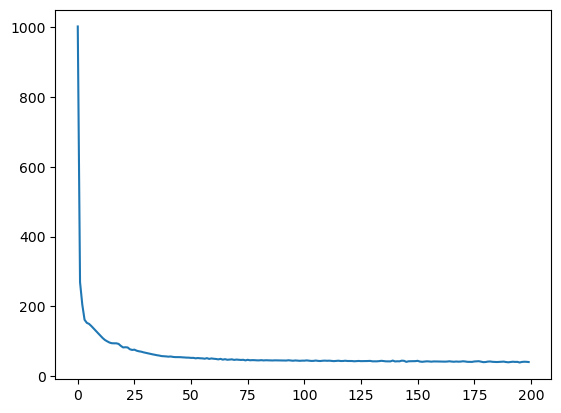

In [50]:
plt.plot(m.train_loss_history)

In [51]:
pred_train_Y = m.predict(cement_X)
# pred_test_Y = m.predict(cement_test_X)
print("R2 for Train set:",r2_score(pred_train_Y,cement_Y))
# print("R2 for Test set:",r2_score(pred_test_Y,cement_test_Y))

R2 for Train set: 0.8403260033664263


In [25]:
def predictVSactual(actual_y,y_predict,title_label):
    fig,ax=plt.subplots(1,len(actual_y),figsize=(15,15))
    for i,col in enumerate(actual_y,0):
        ax[i].plot(np.ravel(actual_y[i]),
                   np.ravel(y_predict[i]),'o',markeredgecolor="black")
        ax[i].set_title(title_label[i])
        ax[i].set_xlabel('Actual Values')
        ax[i].set_ylabel('Predicted Values')
        ax[i].set(aspect='equal')
        x=ax[i].get_xlim()
        y=ax[i].get_xlim()
        ax[i].plot(x,y, ls="--", c=".3")
    return fig,ax

In [26]:
actual_y_cement=[cement_train_Y,cement_test_Y]
pred_y_cement=[pred_train_Y,pred_test_Y]

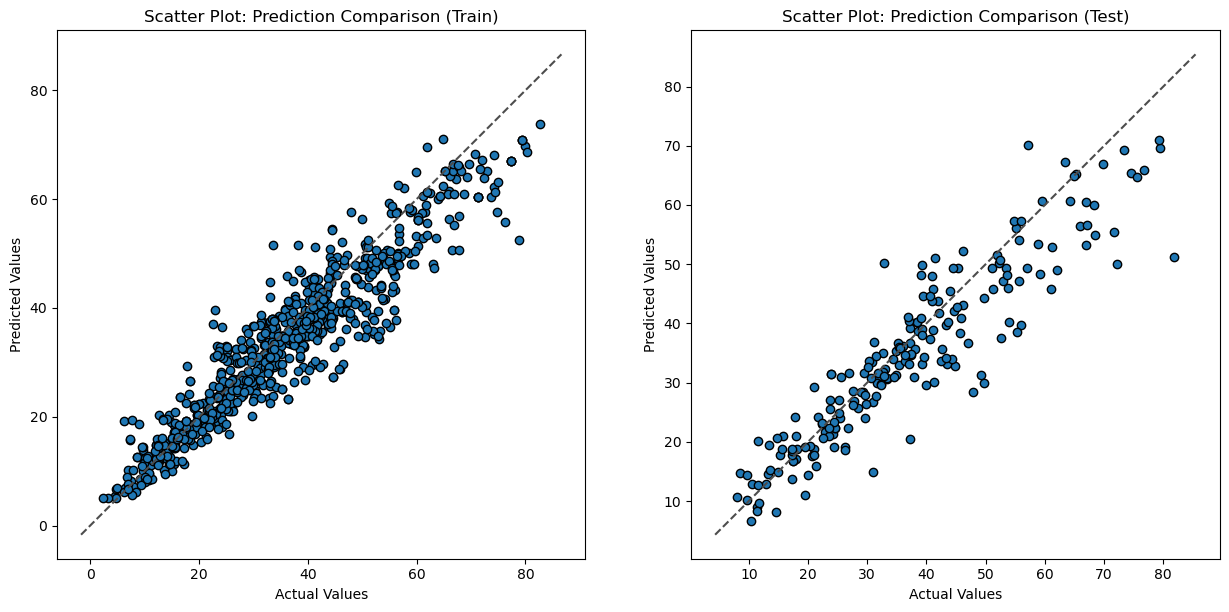

In [27]:
predictVSactual(actual_y_cement,pred_y_cement,
                ["Scatter Plot: Prediction Comparison (Train)","Scatter Plot: Prediction Comparison (Test)"])
plt.show()